# Text Detection and Extraction

### This jupyter-notebook processes images to detect text blocks using a YOLO model, extracts text with Tesseract OCR and visualizes the results.
## Overview of the Code

#### This Python script processes images to detect and extract text, then evaluates the accuracy of the extracted text against ground truth data. Here’s what it does at a high level:

#### 1. **Text Detection**: Uses a YOLO model to identify text blocks in images.
#### 2. **Text Extraction**: Employs Tesseract OCR to extract text from these blocks.
#### 3. **Evaluation**: Compares the extracted text to ground truth text using word-level accuracy and Levenshtein similarity.
#### 4. **Visualization**: Displays an example image with detected text blocks highlighted.

#### The script is designed to work with historical Spanish documents, which influences some of its design choices.

---


## Step-by-Step Explanation
### 1. Importing Libraries

In [3]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ultralytics import YOLO
from paddleocr import PaddleOCR
from pathlib import Path
import pytesseract
import re
from collections import defaultdict
from Levenshtein import distance as levenshtein_distance

### 2. Setting Up Paths and Variables
#### Here I have used custom dataset made using label-studios consisting images provided by HumanAI. This image only contains 32 images as annotating is a long tedious task.

In [57]:
IMAGE_DIR = "Layout-3TextExtract"  # Directory containing images
TXT_DIR = "transcriptions1"  # Directory containing ground truth .txt files
MODEL_PATH = "best.pt"  # This is custom model check out my github to get the weights (There is the detailed explanation of how this model was trained)
OUTPUT_DIR = "output"  # Output directory
EXTRACTED_LAYOUTS_DIR = os.path.join(OUTPUT_DIR, "extracted_layouts")  # For cropped text blocks
EXTRACTED_TEXTS_DIR = os.path.join(OUTPUT_DIR, "extracted_texts")  # For extract
EVALUATION_CSV_PATH = os.path.join(OUTPUT_DIR, "evaluation_results.csv")
NEW_CSV_PATH = os.path.join(OUTPUT_DIR, "combined_results.csv")

In [45]:
os.makedirs(EXTRACTED_LAYOUTS_DIR, exist_ok=True)
os.makedirs(EXTRACTED_TEXTS_DIR, exist_ok=True)

### 3. Setting Up Custom Trained Yolo model Best fit for Historical Documents
This model was trained on the dataset given by HumanAI and also large datasets for document layout extraction present on roboflow.
Checkout the detailed explanation of how this model was trained on my github.
### GitHub Repository

Check out the code on GitHub: [Cool Project](https://github.com/janedoe/cool-project)


In [47]:
print("Loading YOLO model...")
yolo_model = YOLO(MODEL_PATH)

Loading YOLO model...


In [49]:
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_files)} images in {IMAGE_DIR}")

Found 32 images in Layout-3TextExtract


### 4. Loading the OCR.
#### I am using the Tesseract-OCR for extracting text.
#### Reasons being that tesseract is quite good at handling documents with distorted text such as these historical documents and also tesseract has a model that is pretrained on spanish data and is good at extracting spanish text.
#### **Tesseract-OCR**: Tesseract extracts text with the configuration `--oem 3 --psm 3 -l spa`:
  #### - `--oem 3`: Default OCR engine mode.
  #### - `--psm 3`: Assumes a single uniform text block (suitable for document snippets).
  #### - `-l spa`: Uses the Spanish language model (`spa.traineddata`).
### Why Use `spa.traineddata`?
#### - **What**: The `-l spa` flag tells Tesseract to use the Spanish language model (`spa.traineddata`).
#### - **Why**: This script targets Spanish text, likely historical documents. The Spanish model is trained to recognize:
  ####  - Spanish-specific characters (e.g., 'ñ', 'á', 'é', 'í', 'ó', 'ú').
  #### - Linguistic patterns of Spanish words.
  #### Using `spa.traineddata` improves OCR accuracy for Spanish compared to the default English model (`eng.traineddata`), especially for accented characters or historical variants.


In [51]:
pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'  # Windows

In [52]:
tesseract_config = r'--oem 3 --psm 6 -l spa'

In [53]:
image_files = [f for f in os.listdir(IMAGE_DIR) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
print(f"Found {len(image_files)} images in {IMAGE_DIR}")

Found 32 images in Layout-3TextExtract


### Encoding issue.
#### The encoding issue arises when text data, especially from historical documents or OCR output, contains characters that are misinterpreted due to mismatched or incorrect character encodings. This is common when dealing with non-ASCII characters (e.g., accented letters in Spanish like ñ, á, é) or special characters (e.g., the long "s" ſ in historical texts).
#### Since 'ñ' is a non-ASCII it is predicted as 'Ã±' this is common issue when dealing with accents. This function fixes that issue.
#### Historical Spanish texts often use characters like the long "s" (ſ), which Tesseract might misinterpret as f or leave as-is, causing mismatches during evaluation

In [54]:
def clean_historical_text(text):
    # Join if it's a list
    if isinstance(text, list):
        text = " ".join(text)

    # Replace long "s" misinterpretations
    text = text.replace('ſ', 's')  # Tesseract may already handle this, but normalize for comparison
    text = re.sub(r'f(?=[aeiouáéíóúh])', 's', text, flags=re.IGNORECASE)
    text = re.sub(r'suerza', 'fuerza', text)  # Avoid incorrect replacements

    # Fix encoding issues (less common with Tesseract, but just in case)
    text = text.replace('Ã±', 'ñ')
    text = text.replace('Ã¡', 'á')
    text = text.replace('Ã©', 'é')
    text = text.replace('Ã­', 'í')
    text = text.replace('Ã³', 'ó')
    text = text.replace('Ãº', 'ú')
    text = text.replace('Ã', 'í')

    # Remove extra punctuation and normalize spaces
    text = re.sub(r'[^\w\s]', '', text)  # Remove punctuation
    text = re.sub(r'\s+', ' ', text)  # Normalize spaces

    return text.strip().lower()

# Dictionary to store results for evaluation
results = defaultdict(dict)


### 5. Extracting text.
#### Extracting the text blocks from the image, then extracting the text from the text block. Further saving the extracted image and  and the text block. Check out the github repository for the result. [Cool Project](https://github.com/janedoe/cool-project)

In [58]:
for image_file in image_files:
    image_path = os.path.join(IMAGE_DIR, image_file)
    image_name = os.path.splitext(image_file)[0]
    print(f"\nProcessing {image_file}...")

    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Failed to load image: {image_path}")
        continue
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Step 4.1: Use YOLO to detect text blocks
    print("Detecting text blocks with YOLO...")
    yolo_results = yolo_model(image_rgb, conf=0.3)

    # Extract bounding boxes
    text_blocks = []
    for result in yolo_results:
        boxes = result.boxes.xyxy.cpu().numpy()
        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            text_block = image[y1:y2, x1:x2]
            text_blocks.append((text_block, (x1, y1, x2, y2)))

    # Step 4.2: Save cropped text blocks and extract text with Tesseract
    extracted_texts = []
    for idx, (text_block, bbox) in enumerate(text_blocks):
        crop_filename = f"{image_name}_textblock_{idx}.jpg"
        crop_path = os.path.join(EXTRACTED_LAYOUTS_DIR, crop_filename)
        cv2.imwrite(crop_path, text_block)
        print(f"Saved cropped text block: {crop_path}")

        gray = cv2.cvtColor(text_block, cv2.COLOR_BGR2GRAY)
        _, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

        print(f"Extracting text from text block {idx}...")
        extracted_text = pytesseract.image_to_string(thresh, config=tesseract_config)
        extracted_texts.append(extracted_text.strip())

    # Step 4.3: Save the extracted text
    extracted_text_filename = f"{image_name}.txt"
    extracted_text_path = os.path.join(EXTRACTED_TEXTS_DIR, extracted_text_filename)
    with open(extracted_text_path, 'w', encoding='utf-8') as f:
        f.write("\n".join(extracted_texts))
    print(f"Saved extracted text: {extracted_text_path}")

    # Clean and normalize the extracted text
    cleaned_extracted_text = clean_historical_text(extracted_texts)
    results[image_name]['extracted_text'] = cleaned_extracted_text.split()

    # Step 4.4: Load the ground truth text
    ground_truth_path = os.path.join(TXT_DIR, f"{image_name}.txt")
    if not os.path.exists(ground_truth_path):
        print(f"Ground truth file not found: {ground_truth_path}")
        results[image_name]['ground_truth'] = []
        continue

    with open(ground_truth_path, 'r', encoding='utf-8') as f:
        ground_truth_text = f.read().strip()
    cleaned_ground_truth = clean_historical_text(ground_truth_text)
    results[image_name]['ground_truth'] = cleaned_ground_truth.split()
    results[image_name]['raw_ground_truth'] = ground_truth_text


Processing Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6b8ac0193ef53ed053f55ba65.jpg...
Detecting text blocks with YOLO...

0: 640x640 5 Images, 5 texts, 67.3ms
Speed: 2.1ms preprocess, 67.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)
Saved cropped text block: output\extracted_layouts\Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6b8ac0193ef53ed053f55ba65_textblock_0.jpg
Extracting text from text block 0...
Saved cropped text block: output\extracted_layouts\Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6b8ac0193ef53ed053f55ba65_textblock_1.jpg
Extracting text from text block 1...
Saved cropped text block: output\extracted_layouts\Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6b8ac0193ef53ed053f55ba65_textblock_2.jpg
Extracting text from text block 2...
Saved cropped text block: output\extracted_layouts\Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6b8ac0193ef53ed053f55ba65_textblock_3.jpg
Extracting text from text block 3...
Saved cropped text block: output\extract

### 6. Evaluation Process

### Word-Level Accuracy with Partial Matching
#### - **How**: For each extracted word, the script finds the closest ground truth word using Levenshtein distance. If the distance is ≤ 2 (allowing minor errors like typos), it’s a match.
#### - **Calculation**: Accuracy = (number of matched words / total extracted words) × 100.
#### - **Why**: This measures how well individual words are extracted, tolerating small OCR errors common in historical texts (e.g., 'hola' vs. 'holá').

###  Levenshtein Similarity
#### - **How**: The full extracted text and ground truth text are compared using Levenshtein distance (number of edits needed to transform one into the other). Similarity is calculated as:
  ```python
  lev_similarity = 1 - (lev_distance / max_length)
  ```
  #### where `max_length` is the length of the longer text.
#### - **Why**: This gives a holistic view of text similarity, accounting for insertions, deletions, and substitutions across the entire text.



### Storing and Saving Results
Evaluation details (status, accuracy, similarity, etc.) are stored in a list, converted to a `pandas` DataFrame, and saved to two CSV files: `evaluation.csv` and `combined_results.csv`.


In [59]:
print("\nEvaluating the model...")
total_images = len(results)
correct_images = 0
evaluation_details = []

for image_name, data in results.items():
    extracted_words = data.get('extracted_text', [])
    ground_truth = data.get('ground_truth', [])
    raw_ground_truth = data.get('raw_ground_truth', '')

    if not ground_truth:
        print(f"No ground truth for {image_name}, skipping evaluation.")
        continue

    # Calculate word-level accuracy with partial matching
    correct_words = 0
    total_extracted = len([w for w in extracted_words if w])
    missing_words = []
    for word in extracted_words:
        if not word:
            continue
        best_match = min(ground_truth, key=lambda gt: levenshtein_distance(word, gt), default="")
        if best_match:
            # Consider a match if the Levenshtein distance is small (e.g., <= 2)
            if levenshtein_distance(word, best_match) <= 2:
                correct_words += 1
            else:
                missing_words.append(word)
        else:
            missing_words.append(word)

    # Calculate Levenshtein distance for the full text
    extracted_full = " ".join(extracted_words)
    ground_truth_full = " ".join(ground_truth)
    lev_distance = levenshtein_distance(extracted_full, ground_truth_full)
    max_length = max(len(extracted_full), len(ground_truth_full))
    lev_similarity = 1 - (lev_distance / max_length) if max_length > 0 else 0

    # Word-level accuracy
    word_accuracy = (correct_words / total_extracted) * 100 if total_extracted > 0 else 0

    # Consider the image "correct" if word accuracy is above a threshold (e.g., 50%)
    threshold = 50  # Lowered threshold
    if word_accuracy >= threshold:
        correct_images += 1
        status = f"Correct (Word Accuracy: {word_accuracy:.2f}%, Levenshtein Similarity: {lev_similarity:.2f})"
    else:
        status = f"Incorrect (Word Accuracy: {word_accuracy:.2f}%, Levenshtein Similarity: {lev_similarity:.2f}, Missing: {', '.join(missing_words)})"

    evaluation_details.append({
        'Image': image_name,
        'Status': status,
        'Extracted Text': " ".join(extracted_words),
        'Ground Truth Text': raw_ground_truth,
        'Missing Words': ", ".join(missing_words),
        'Word Accuracy (%)': word_accuracy,
        'Levenshtein Similarity': lev_similarity
    })


Evaluating the model...
No ground truth for Constituciones-sinodales-Calahorra-1602_pdf_page_1_png.rf.224a39c994a0ebe3c052aee74a36d165, skipping evaluation.
No ground truth for Constituciones-sinodales-Calahorra-1602_pdf_page_2_png.rf.59b2f2b9ee344d9106aefa4598d78084, skipping evaluation.
No ground truth for Constituciones-sinodales-Calahorra-1602_pdf_page_4_png.rf.e4a6820aadf62a1ce5c619220cb7d863, skipping evaluation.
No ground truth for Constituciones-sinodales-Calahorra-1602_pdf_page_5_png.rf.a3e5c87bfbd3cf34c01ca0fa402799b0, skipping evaluation.
No ground truth for Constituciones-sinodales-Calahorra-1602_pdf_page_6_png.rf.1b20a833bc4c8b3c040818f65e0d5223, skipping evaluation.


### Accuracy

#### The overall accuracy of the model is 81.25%
#### Average Word-Level = 91.00515557 %
#### Average Levenshtein Similarity = 0.704979

## Overview of the Evaluation Process

The evaluation section of your code measures how well the extracted text matches the ground truth text for each image. It uses two metrics:
1. **Word-Level Accuracy**: Measures the percentage of extracted words that match ground truth words, allowing for small differences (using Levenshtein distance).
2. **Levenshtein Similarity**: Measures the overall similarity between the full extracted text and ground truth text.

The **accuracy** of the model (reported as a percentage at the end) is based on the number of images where the word-level accuracy exceeds a threshold (50%). Let’s focus on how this word-level accuracy is calculated, as it directly influences the overall accuracy.



## Step-by-Step Explanation of Accuracy Calculation

### 1. **Extracted and Ground Truth Words**
For each image, the script has:
- `extracted_words`: A list of words from the OCR output, after cleaning with `clean_historical_text`.
- `ground_truth`: A list of words from the ground truth text, also cleaned.

These lists are stored in the `results` dictionary for each image:
```python
extracted_words = data.get('extracted_text', [])
ground_truth = data.get('ground_truth', [])
```

### 2. **Word-Level Accuracy with Partial Matching**
The script calculates word-level accuracy by comparing each extracted word to the ground truth words, allowing for small differences using the Levenshtein distance.


- **Filter Empty Words**:
  - `total_extracted = len([w for w in extracted_words if w])`: Counts non-empty words in `extracted_words`. Empty strings (e.g., from OCR errors) are excluded to avoid skewing the count.
  - **Why**: Ensures only meaningful words contribute to the accuracy calculation.


- **Find Best Match**:
  - `best_match = min(ground_truth, key=lambda gt: levenshtein_distance(word, gt), default="")`: Finds the ground truth word with the smallest Levenshtein distance to the extracted word.
  - **Levenshtein Distance**: Measures the minimum number of single-character edits (insertions, deletions, substitutions) needed to transform one word into another. For example, `levenshtein_distance("cat", "hat") = 1` (one substitution: c → h).
  - **Why**: Allows partial matching, so small OCR errors (e.g., "hola" vs. "holá") are still considered correct.

- **Determine Correctness**:
  - `if best_match and levenshtein_distance(word, best_match) <= 2`: A word is considered correct if its best match in the ground truth has a Levenshtein distance of 2 or less.
  - **Threshold of 2**: Allows for minor errors (e.g., one or two character differences). For example:
    - "hola" vs. "holá" (distance = 1, correct).

  - **Why**: Historical texts and OCR often introduce small errors (e.g., accented characters, misread letters). A threshold of 2 balances leniency and accuracy.
  - If correct, `correct_words += 1`; otherwise, the word is added to `missing_words` for reporting.

## Role of Levenshtein Similarity

- **Purpose**: Measures overall text similarity, complementing word-level accuracy by capturing structural differences (e.g., missing or extra phrases).
- **Why Not Used in Accuracy?**: It’s a broader metric, less granular than word-level accuracy, and is included in the evaluation report for context.



Evaluation Summary:
Accuracy: 81.25%

Detailed Evaluation:


,Image,Status,Extracted Text,Ground Truth Text,Missing Words,Word Accuracy (%),Levenshtein Similarity
0,Buendia-Instruccion_pdf_page_1_png.rf.31aa8df6...,"Correct (Word Accuracy: 97.14%, Levenshtein Si...",1e m ee dg __jw hr tir como niño entre los doé...,"Vos , Dulcifsimo Niño\nJESUS , que no folo os ...","__jw, lagituloes, inennití",97.142857,0.689034
1,Buendia-Instruccion_pdf_page_2_png.rf.3dfe8354...,"Correct (Word Accuracy: 96.37%, Levenshtein Si...",viísimos abrazos dichosa edad msito que o5 mer...,guro diſſeño de su edad : la Reli-\ngion para ...,"exbe, urodiseño, paracon, afsiltéciad, tarque,...",96.369637,0.270073
2,Buendia-Instruccion_pdf_page_3_png.rf.1507d0da...,"Correct (Word Accuracy: 91.63%, Levenshtein Si...",de orden del nuftre señor doñ friz cifco de ba...,crianza de la Niñez . Afsi sea;\nDivinifsimo N...,"nuftre, baliero, sastiftán, luftrifsimo, geron...",91.627907,0.402259
3,Buendia-Instruccion_pdf_page_4_png.rf.e61e9006...,"Correct (Word Accuracy: 97.91%, Levenshtein Si...",cabaliero muy santos por rodo lo qual 4 mas de...,"Antonio Codorniu , de la\nCompañia de Jeſus \n...","conciertoque, muefras, bídn, 15salil, 1cmim",97.907950,0.740968
4,Buendia-Instruccion_pdf_page_5_png.rf.e356bea2...,"Correct (Word Accuracy: 98.42%, Levenshtein Si...",hemos de dár en otro mas severo eribuz mal qui...,hemos de dár en otro mas ſevero tribu-\nnal . ...,"reála, artísio, aciertohan, 1í_fcn, afsilosiento",98.417722,0.930711
5,Buendia-Instruccion_pdf_page_6_png.rf.4d6abc76...,"Correct (Word Accuracy: 96.04%, Levenshtein Si...",de la obra a devocion y aseño que delde mis l ...,"MOTIVO DEL AUTHOR , Y RAZON\nde la Obra .\n\nA...","infruirles, lm_sn, añaroa, 2nfraccion, ctrisio...",96.039604,0.607185
6,Ezcaray-Vozes_pdf_page_10_png.rf.e098b341498eb...,"Correct (Word Accuracy: 97.52%, Levenshtein Si...",en los caxones de palacio dóride por mis pecad...,"en los caxones de Palacio , donde ( por\nmis p...","dóride, necefflidad, poderdezir, vslguesabe",97.515528,0.941606
7,Ezcaray-Vozes_pdf_page_11_png.rf.86e6c9ec0da33...,"Correct (Word Accuracy: 96.34%, Levenshtein Si...",frantonio de excaray las prensas efto es dar v...,las prenſas ( eſto es dar vozes los mol-\ndes ...,"ilegaransi, luftridimo, lluftrisimo",96.341463,0.479167
8,Ezcaray-Vozes_pdf_page_1_png.rf.868929ed16b784...,"Correct (Word Accuracy: 93.48%, Levenshtein Si...",eyo cupado en cl exercicio de __xfº k de las m...,Cupado en el exercicio\nde las Miffiones en el...,"__xfº, recibivna, apoftolicatuve, midbli, guci...",93.478261,0.490998
9,Ezcaray-Vozes_pdf_page_2_png.rf.fef088e98e91e5...,"Correct (Word Accuracy: 95.62%, Levenshtein Si...",a eftos dos nombres dn mifterio sas interprera...,A eſtos dos nombres dan miſterio-\nfas interpr...,"sasorcorazonseñor, grmdc, corezanociory, alisa...",95.620438,0.889820



Saved evaluation results to output\evaluation_results.csv
Saved combined results to output\combined_results.csv

0: 640x640 5 Images, 5 texts, 77.7ms
Speed: 2.4ms preprocess, 77.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


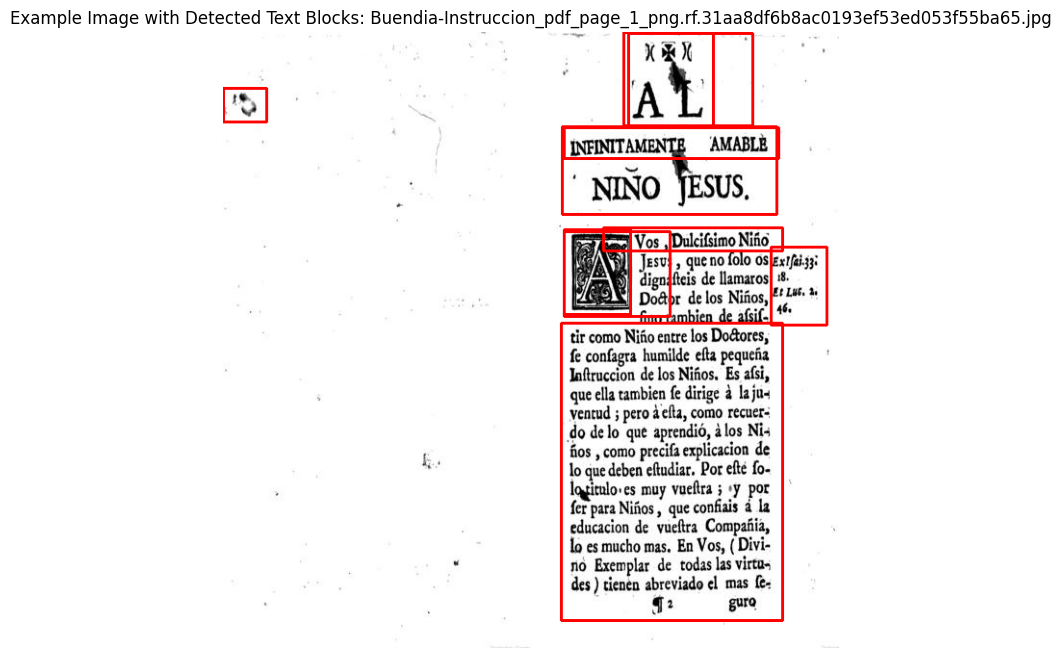

In [60]:
accuracy = (correct_images / total_images) * 100 if total_images > 0 else 0
print(f"\nEvaluation Summary:")

print(f"Accuracy: {accuracy:.2f}%")

# Display detailed evaluation
eval_df = pd.DataFrame(evaluation_details)
print("\nDetailed Evaluation:")
display(eval_df)

# Step 7: Save evaluation results to CSV
eval_df.to_csv(EVALUATION_CSV_PATH, index=False, encoding='utf-8')
print(f"\nSaved evaluation results to {EVALUATION_CSV_PATH}")

# Step 8: Save a new combined CSV with evaluation and transcriptions
eval_df.to_csv(NEW_CSV_PATH, index=False, encoding='utf-8')
print(f"Saved combined results to {NEW_CSV_PATH}")

# Optional: Visualize an example with bounding boxes
if image_files:
    example_image = image_files[0]
    example_image_path = os.path.join(IMAGE_DIR, example_image)
    example_image_rgb = cv2.cvtColor(cv2.imread(example_image_path), cv2.COLOR_BGR2RGB)

    yolo_results = yolo_model(example_image_rgb, conf=0.3)
    for result in yolo_results:
        boxes = result.boxes.xyxy.cpu().numpy()
        for box in boxes:
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(example_image_rgb, (x1, y1), (x2, y2), (255, 0, 0), 2)

    plt.figure(figsize=(10, 8))
    plt.imshow(example_image_rgb)
    plt.title(f"Example Image with Detected Text Blocks: {example_image}")
    plt.axis('off')
    plt.show()



Visualizing text blocks and extracted text for Buendia-Instruccion_pdf_page_2_png.rf.3dfe8354b705915ab7602b31ca902f74.jpg...

0: 640x640 5 texts, 144.6ms
Speed: 5.0ms preprocess, 144.6ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)


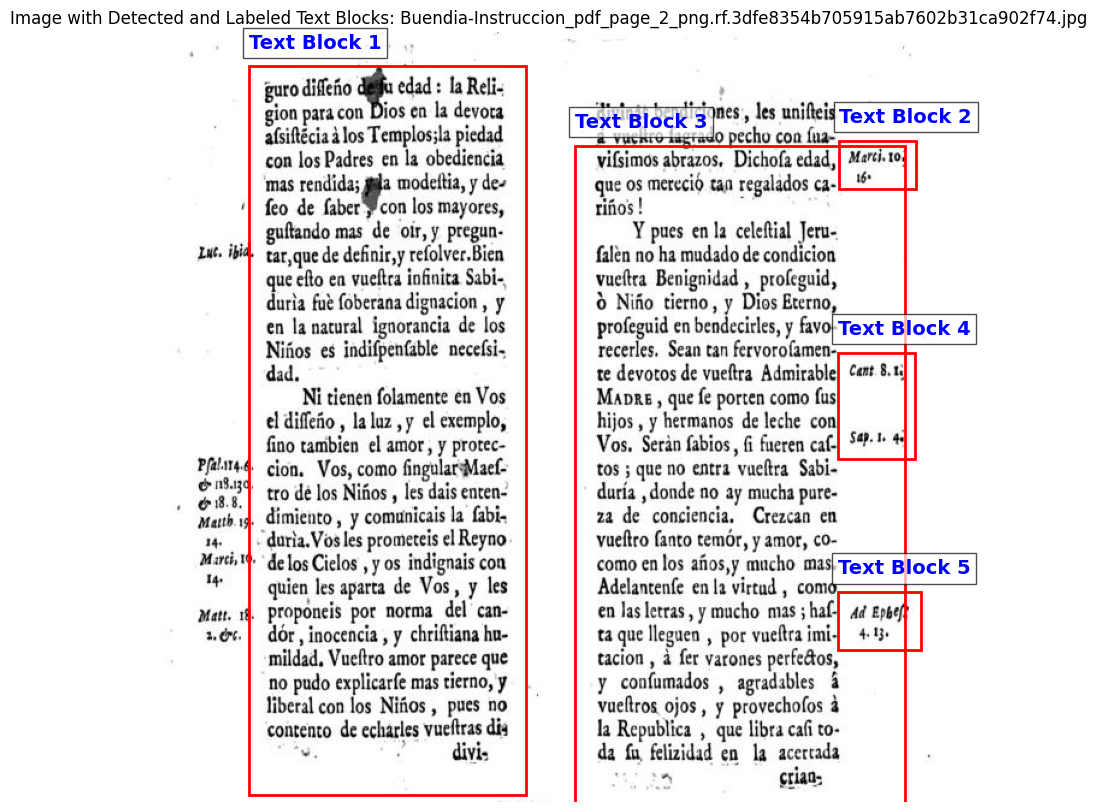


Extracted Text for Each Text Block:

Text Block 1 (Coordinates: (70, 28, 301, 634)):
Extracted Text:
|

duria fue foberana dignacion , y
en la natural ignorancia de los
Niños es indifpenfable necefsi-
dad.

Ni cienen folamente en Vos
el diffeño , la luz , y el excmplo,
fino tambien el amor, y protec-
cion. Vos, como fingularMaef-
tro de los Niños , les dais enten-
dimicuro , y comunicais la fabi-

- duria,Vos les prometeis el Reyno

de los Cielos . y os indignaís con

Text Block 2 (Coordinates: (561, 90, 625, 130)):
Extracted Text:
farci. 10
16*

Text Block 3 (Coordinates: (341, 94, 616, 640)):
Extracted Text:
— — _ _ — R —
profeguid en bendecirles, y favo-
recerles. Scan tan fervorolamen-
te devotos de vueltra Admirable
Mapre, que fe porten como fus
hijos , y hermanos de leche con
Vos. Serán fabios, i fueren caf-
tos ; que no entra vueltra Sabi-
duría , donde no ay mucha pure-
za de conciencia. Crezcan en
vueltro fanto temór, y amor, co-
como en los años,y mucho mas.
Adelantenfe en l

In [62]:
if image_files:
    # Select an example image (e.g., the second image in the dataset)
    example_image = image_files[1]
    example_image_path = os.path.join(IMAGE_DIR, example_image)
    example_image_rgb = cv2.cvtColor(cv2.imread(example_image_path), cv2.COLOR_BGR2RGB)

    # Step 1: Detect text blocks with YOLO
    print(f"\nVisualizing text blocks and extracted text for {example_image}...")
    yolo_results = yolo_model(example_image_rgb, conf=0.5)  # Adjusted confidence threshold from 0.3 to 0.5

    # Step 2: Extract bounding boxes and prepare for visualization
    text_blocks = []
    for result in yolo_results:
        boxes = result.boxes.xyxy.cpu().numpy()
        for idx, box in enumerate(boxes):
            x1, y1, x2, y2 = map(int, box)
            # Filter out small or invalid boxes
            if (x2 - x1) > 50 and (y2 - y1) > 20:  # Adjust thresholds based on your images
                text_block = example_image_rgb[y1:y2, x1:x2]  # Crop the text block in RGB
                text_blocks.append((text_block, (x1, y1, x2, y2)))

    # Step 3: Sort text blocks by y-coordinate (top to bottom) for reading order
    text_blocks.sort(key=lambda b: b[1][1])

    # Step 4: Plot the image with labeled text blocks
    plt.figure(figsize=(12, 10))
    plt.imshow(example_image_rgb)

    # Add bounding boxes and labels
    for idx, (_, (x1, y1, x2, y2)) in enumerate(text_blocks):
        # Draw the bounding box
        rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, linewidth=2, edgecolor='red', facecolor='none')
        plt.gca().add_patch(rect)
        # Add the label (e.g., "Text Block 1") above the box
        label = f"Text Block {idx + 1}"
        plt.text(x1, y1 - 15, label, color='blue', fontsize=14, weight='bold',
                 bbox=dict(facecolor='white', alpha=0.7))

    plt.title(f"Image with Detected and Labeled Text Blocks: {example_image}")
    plt.axis('off')
    plt.show()

    # Step 5: Extract text from each text block using Tesseract and display the results
    print("\nExtracted Text for Each Text Block:")
    for idx, (text_block, (x1, y1, x2, y2)) in enumerate(text_blocks):
        # Preprocessing for Tesseract
        # Resize the image to improve small text recognition
        text_block_resized = cv2.resize(text_block, None, fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
        gray = cv2.cvtColor(text_block_resized, cv2.COLOR_RGB2GRAY)
        # Denoise the image
        adjusted = cv2.medianBlur(gray, 3)
        # Increase contrast
        alpha = 1.5  # Contrast control (1.0-3.0)
        beta = 0     # Brightness control (0-100)
        adjusted = cv2.convertScaleAbs(adjusted, alpha=alpha, beta=beta)
        # Apply adaptive thresholding for uneven lighting
        thresh = cv2.adaptiveThreshold(adjusted, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                       cv2.THRESH_BINARY, 11, 2)

        # Deskew the image
        coords = np.column_stack(np.where(thresh > 0))
        if len(coords) > 0:  # Ensure there are enough points to deskew
            angle = cv2.minAreaRect(coords)[-1]
            if angle < -45:
                angle = -(90 + angle)
            else:
                angle = -angle
            (h, w) = thresh.shape[:2]
            center = (w // 2, h // 2)
            M = cv2.getRotationMatrix2D(center, angle, 1.0)
            thresh = cv2.warpAffine(thresh, M, (w, h), flags=cv2.INTER_CUBIC,
                                    borderMode=cv2.BORDER_REPLICATE)

        # Extract text with Tesseract
        tesseract_config = '--oem 3 --psm 3 -l spa'  # Adjusted config; replace with your original if custom
        extracted_text = pytesseract.image_to_string(thresh, config=tesseract_config).strip()

        # Post-process text (e.g., replace long "s" with regular "s" for historical text)
        extracted_text = extracted_text.replace('ſ', 's')

        # Display the extracted text for this text block
        print(f"\nText Block {idx + 1} (Coordinates: ({x1}, {y1}, {x2}, {y2})):")
        print(f"Extracted Text:\n{extracted_text}")

## Visualization
#### As you can see the YOLO model is great at identifying the text blocks. It does has problem in identifying the text blocks near the margins.

#### For the image, the script:
####  - Runs YOLO to detect text blocks.
#### - Draws red bounding boxes around them.
#### - Extracts the text from the bonding box.
#### - Displays the annotated image using Matplotlib.
#### - Displays the extracted text.

#### This helps verify visually whether the text blocks were detected correctly.



## Summary

This code:
- **Detects** text blocks with YOLO.
- **Extracts** text using Tesseract with `spa.traineddata` for Spanish accuracy.
- **Evaluates** performance with word accuracy and Levenshtein similarity.
- **Handles Text**: Cleans text to address historical or encoding quirks.
- **Visualizes** results for verification.
